Files already downloaded and verified
Training complete. Generated images and scores saved.


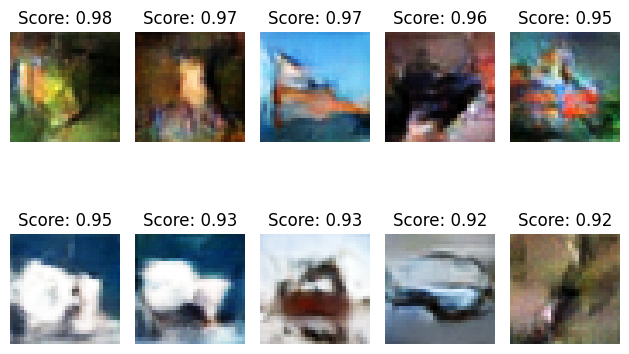

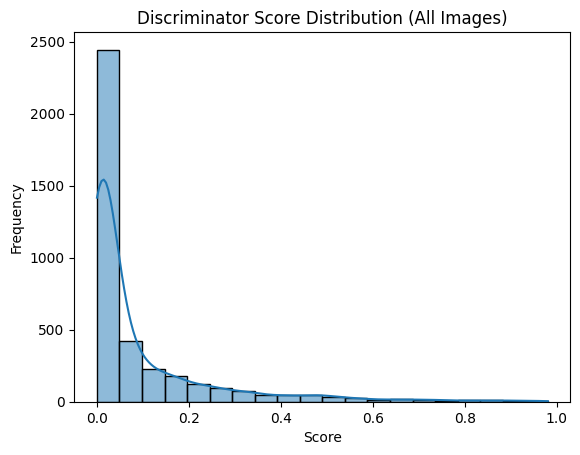

Found 3840 image files in directory.
Loaded 3840 images for IS calculation.
Inception Score: mean_is 3.70 ± 0.30


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image
from torchvision.models import inception_v3
import torch.nn.functional as F
from PIL import Image
import numpy as np
from scipy.stats import entropy
import warnings
import seaborn as sns

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
epochs = 60
z_dim = 100
lr = 0.0002
beta1 = 0.5
img_size = 32
channels = 3  # RGB for CIFAR-10

# Data preparation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

# Initialize models
generator = Generator(z_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for consistent evaluation
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Create a dictionary to store generated images and their scores
generated_images_scores = {}

# Training loop
os.makedirs("generated_images", exist_ok=False) 
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Real and fake labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(imgs), real_labels)
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_g.step()

    # Evaluate and save generated images
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).cpu()
        scores = discriminator(fake_imgs.to(device)).cpu().detach().numpy().flatten()  # Scores for evaluation
        for idx, (img, score) in enumerate(zip(fake_imgs, scores)):
            filename = f"generated_images/epoch_{epoch}_img_{idx}.png"
            save_image(img, filename, normalize=True)
            generated_images_scores[filename] = score

print("Training complete. Generated images and scores saved.")

# Sort the images by score (descending order)
top_10_images = sorted(generated_images_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# Display top 10 images and their scores
for i, (filename, score) in enumerate(top_10_images):
    img = Image.open(filename)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Score: {score:.2f}")

plt.tight_layout()
plt.show()

# Discriminator Score Distribution (for all images)
all_scores = list(generated_images_scores.values())  
sns.histplot(all_scores, bins=20, kde=True)  
plt.title("Discriminator Score Distribution (All Images)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Inception Score
# Suppress specific future UserWarning messages
warnings.filterwarnings(
    "ignore", 
    message="The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future"
)
warnings.filterwarnings(
    "ignore", 
    message="Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future"
)

# Path to the directory containing generated images
generated_images_dir = "generated_images/"

# List all image file paths in the directory
generated_image_paths = [
    os.path.join(generated_images_dir, fname)
    for fname in os.listdir(generated_images_dir)
    if fname.endswith(('.png', '.jpg', '.jpeg'))
]

# Debugging: Check how many images were found
print(f"Found {len(generated_image_paths)} image files in directory.")

# Load images
generated_images = [Image.open(path).convert("RGB") for path in generated_image_paths]

# Define the transform to preprocess generated images
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the pre-trained Inception model
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.eval()
inception_model.to(device)

def calculate_inception_score(images, splits=10):
    """Compute the Inception Score for a list of generated images."""
    preds = []

    with torch.no_grad():
        for img in images:
            img = transform(img).unsqueeze(0).to(device)
            pred = inception_model(img).softmax(dim=-1).cpu().numpy()
            preds.append(pred)

    preds = np.concatenate(preds, axis=0)
    scores = []

    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits), :]
        kl_div = entropy(part.T, np.mean(part, axis=0, keepdims=True).T)
        scores.append(np.exp(np.mean(kl_div)))

    return np.mean(scores), np.std(scores)

# Debugging: Check how many images were loaded
print(f"Loaded {len(generated_images)} images for IS calculation.")

# Compute IS
mean_is, std_is = calculate_inception_score(generated_images)
print(f"Inception Score: mean_is {mean_is:.2f} ± {std_is:.2f}")

Files already downloaded and verified
Training complete. Generated images and scores saved.


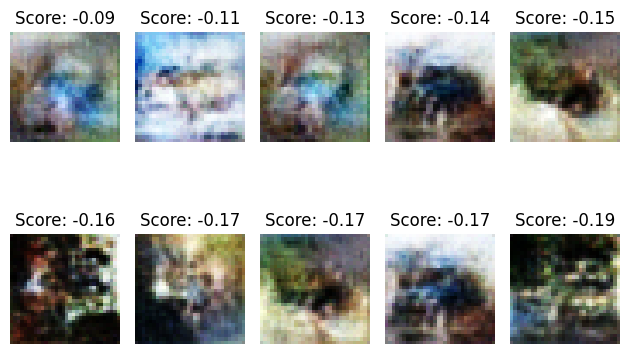

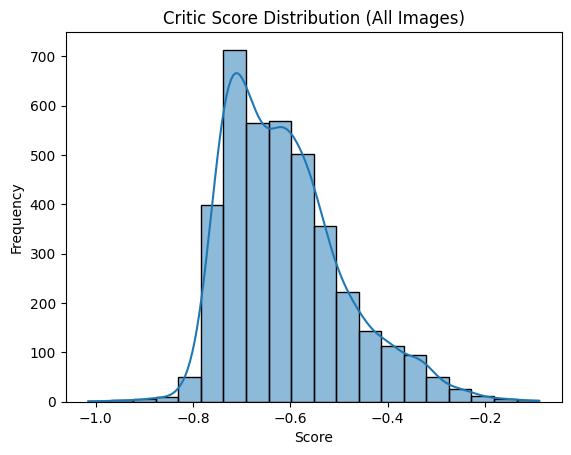

Found 3840 image files in directory.
Loaded 3840 images for IS calculation.
Inception Score: mean_is 2.14 ± 0.14


In [4]:
# Hyperparameters
lr = 0.00005  # Lower learning rate for WGAN
clip_value = 0.01  # Weight clipping value

# Data preparation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Critic in WGAN
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

# Initialize models
generator = Generator(z_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for consistent evaluation
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Create a dictionary to store generated images and their scores
generated_images_scores = {}

# Training loop
os.makedirs("generated_images_W", exist_ok=False) 
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Train Discriminator (Critic)
        optimizer_d.zero_grad()
        real_loss = discriminator(imgs).mean()
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = generator(z)
        fake_loss = discriminator(fake_imgs.detach()).mean()
        d_loss = fake_loss - real_loss
        d_loss.backward()
        optimizer_d.step()

        # Weight clipping
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train Generator (less frequently)
        if i % 5 == 0:
            optimizer_g.zero_grad()
            g_loss = -discriminator(fake_imgs).mean()
            g_loss.backward()
            optimizer_g.step()

    # Evaluate and save generated images
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).cpu()
        scores = discriminator(fake_imgs.to(device)).cpu().detach().numpy().flatten()
        for idx, (img, score) in enumerate(zip(fake_imgs, scores)):
            filename = f"generated_images_W/epoch_{epoch}_img_{idx}.png"
            save_image(img, filename, normalize=True)
            generated_images_scores[filename] = score

print("Training complete. Generated images and scores saved.")

# Sort the images by score (descending order)
top_10_images = sorted(generated_images_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# Display top 10 images and their scores
for i, (filename, score) in enumerate(top_10_images):
    img = Image.open(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Score: {score:.2f}")

plt.tight_layout()
plt.show()

# Critic Score Distribution (for all generated images)
all_scores = list(generated_images_scores.values()) 
sns.histplot(all_scores, bins=20, kde=True) 
plt.title("Critic Score Distribution (All Images)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Path to the directory containing generated images
generated_images_dir = "generated_images_W/"

# List all image file paths in the directory
generated_image_paths = [
    os.path.join(generated_images_dir, fname)
    for fname in os.listdir(generated_images_dir)
    if fname.endswith(('.png', '.jpg', '.jpeg'))
]

print(f"Found {len(generated_image_paths)} image files in directory.")

# Load images for Inception Score calculation
generated_images = [Image.open(path).convert("RGB") for path in generated_image_paths]

# Define the transform to preprocess generated images
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Required by Inception
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the pre-trained Inception model
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.eval()
inception_model.to(device)

# Function to calculate the Inception Score
def calculate_inception_score(images, splits=10):
    """Compute the Inception Score for a list of generated images."""
    preds = []

    with torch.no_grad():
        for img in images:
            img = transform(img).unsqueeze(0).to(device)
            pred = inception_model(img).softmax(dim=-1).cpu().numpy()
            preds.append(pred)

    preds = np.concatenate(preds, axis=0)
    scores = []

    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits), :]
        kl_div = entropy(part.T, np.mean(part, axis=0, keepdims=True).T)
        scores.append(np.exp(np.mean(kl_div)))

    return np.mean(scores), np.std(scores)

print(f"Loaded {len(generated_images)} images for IS calculation.")

# Compute and print Inception Score
mean_is, std_is = calculate_inception_score(generated_images)
print(f"Inception Score: mean_is {mean_is:.2f} ± {std_is:.2f}")

Files already downloaded and verified
Training complete. Generated images and scores saved.


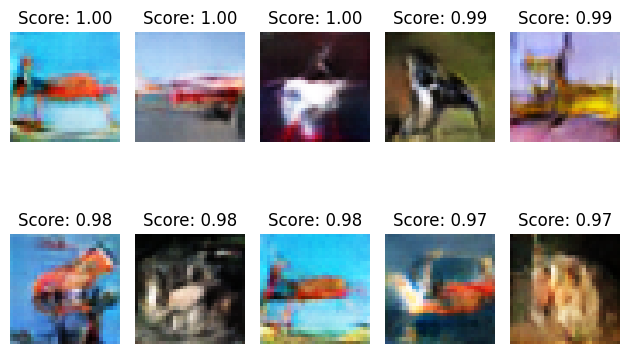

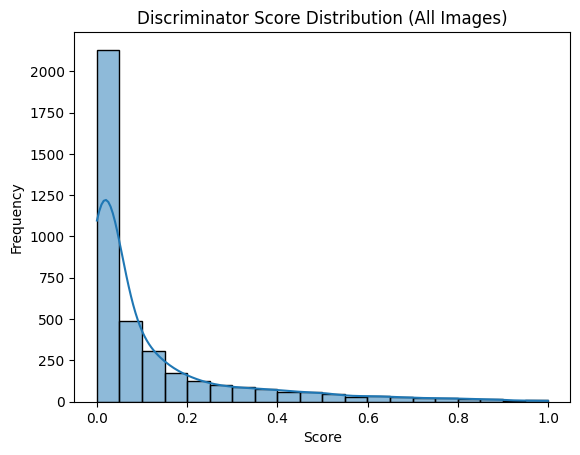

Found 3840 image files in directory.
Inception Score: mean_is 4.11 ± 0.39


In [11]:
# Hyperparameters
lr = 0.0002

# Data preparation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

# Initialize models
generator = Generator(z_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for consistent evaluation
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Create directories
os.makedirs("generated_images_AC", exist_ok=False)

# Create a dictionary to store generated images and their scores
generated_images_scores = {}

# Training
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Real and fake labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        optimizer_d.zero_grad()
        real_loss = criterion(discriminator(imgs), real_labels)
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_g.step()

    # Evaluate and save generated images
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).cpu()
        scores = discriminator(fake_imgs.to(device)).cpu().detach().numpy().flatten() 
        for idx, (img, score) in enumerate(zip(fake_imgs, scores)):
            filename = f"generated_images_AC/epoch_{epoch}_img_{idx}.png"
            save_image(img, filename, normalize=True)
            generated_images_scores[filename] = score

print("Training complete. Generated images and scores saved.")

# Aggregate all scores for histogram
all_scores = list(generated_images_scores.values())
# Sort the images by score (descending order)
top_10_images = sorted(generated_images_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# Display top 10 images and their scores
for i, (filename, score) in enumerate(top_10_images):
    img = Image.open(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Score: {score:.2f}")

plt.tight_layout()
plt.show()

# Discriminator Score Distribution (for all scores)
sns.histplot(all_scores, bins=20, kde=True)
plt.title("Discriminator Score Distribution (All Images)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Path to the directory containing generated images
generated_images_dir = "generated_images_AC/"

# List all image file paths in the directory
generated_image_paths = [
    os.path.join(generated_images_dir, fname)
    for fname in os.listdir(generated_images_dir)
    if fname.endswith(('.png', '.jpg', '.jpeg'))
]

print(f"Found {len(generated_image_paths)} image files in directory.")

# Load images
generated_images = [Image.open(path).convert("RGB") for path in generated_image_paths]

# Define the transform to preprocess generated images
transform = transforms.Compose([
    transforms.Resize((299, 299)), 
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the pre-trained Inception model
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.eval()
inception_model.to(device)

def calculate_inception_score(images, splits=10):
    """Compute the Inception Score for a list of generated images."""
    preds = []

    with torch.no_grad():
        for img in images:
            img = transform(img).unsqueeze(0).to(device)
            pred = inception_model(img).softmax(dim=-1).cpu().numpy()
            preds.append(pred)

    preds = np.concatenate(preds, axis=0)
    scores = []

    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits), :]
        kl_div = entropy(part.T, np.mean(part, axis=0, keepdims=True).T)
        scores.append(np.exp(np.mean(kl_div)))

    return np.mean(scores), np.std(scores)

# Compute Inception Score
mean_is, std_is = calculate_inception_score(generated_images)
print(f"Inception Score: mean_is {mean_is:.2f} ± {std_is:.2f}")